In [11]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import subprocess
import sys
from copy import copy
import scipy
import imageio
sys.path.append("../")
import itertools
from scipy.stats import norm
import matplotlib.mlab as mlab
from mvgavg import mvgavg

from useful_func import dtw, get_path, plot_warped_timeseries
from useful_func import spectrum_a, spectrum_d
from useful_func import residuals, exp_decay, get_fit, sigmoid, exp_decay_max
from useful_func import gradient_magnitude, gradient_orientation, gaussian_kernel, assign_orientation, crop_center, cconv, get_algae_im
from numpy import genfromtxt

from joblib import Parallel, delayed
from scipy import optimize
from useful_func import make_svm, make_pca

import skued

import skimage

from useful_func import fit_biexp, fit_exp, fit_monoexp

import tifffile as tiff
import random
%matplotlib widget

# Run all

In [12]:
class activation_experiment():
    def __init__(self, folder):
        self.experiment_folder = folder
        self.activation_HL = glob.glob(folder + "/*constant_light_HL*")
        self.relaxation_LL = glob.glob(folder + "/*constant_light_LL*")
        self.measure = [[], [],[],[]]
        self.measure[0] = glob.glob(folder + "/*qE_calib_0")
        self.measure[1] = glob.glob(folder + "/*qE_calib_1")
        self.measure[2] = glob.glob(folder + "/*qE_calib_2")
        self.measure[3] = glob.glob(folder + "/*qE_calib_3")
        self.dark_relaxation = glob.glob(folder + "/*dark_relaxation*")
        
    
    def get_exp_dicts(self, exp_set):
        exp_dicts = []
        for exp in exp_set:
            exp_dicts.append(np.load(exp + '/items_dict.npy', allow_pickle=True).item())
        return exp_dicts
            
    def times_absolute(self, exp_set): 
        times = []
        
        for exp in exp_set:
            times.append(np.load(exp + "/video_timing.npy"))
        return np.array(times)
    
    def times(self, exp_set): 
        times = self.times_absolute(exp_set)
        return times - np.expand_dims(times[:,0], 1)

    def means(self, exp_set):
        means = []
        exp_dicts = self.get_exp_dicts(exp_set)
        for exp_dict in exp_dicts:
            means.append(exp_dict["total_mean"])        
        return np.array(means)
    
    def read_pulses(self, exp_set):
        pulse_data = []
        for exp in exp_set:
            frames_full = skimage.io.imread(exp + "/video.tiff")
            value = np.sum(frames_full, axis=(1,2))
            frameset = np.mean(frames_full, axis = 0)
            pulse_data.append(value/np.sum(frameset>2))
        return np.array(pulse_data)
        
        
    def get_traces(self, exp_set):
        traces = []
        labels = []
        exp_dicts = self.get_exp_dicts(exp_set)
        i = 0
        for exp_dict in exp_dicts:
 
            for algae in exp_dict["items_dict"].keys():
                s = exp_dict["items_dict"][algae]["surface"]
                if s>5 and s<60:
                    traces.append(exp_dict["items_dict"][algae]["mean"])
                    labels.append(i)
            i += 1
        return np.array(traces), np.array(labels)
    
    
    def get_ratio(self, exp_set, F0, F1):
        traces, labels = self.get_traces(exp_set)
        return (traces[:,F0] - traces[:,F1])/traces[:,F1]
        
        
"""

inds = x==x#x<x.max()*0.4
        time = exp_dict["time"][inds]
        if i==0:
            t0 = time[0]
        time = time-t0
        for algae in exp_dict["items_dict"].keys():
            s = exp_dict["items_dict"][algae]["surface"]

            if s>5 and s<60:
                y = exp_dict["items_dict"][algae]["mean"][inds]
                traces.append(y)
                plt.figure()
                plt.plot(time, y)
                plt.savefig(fname + "/" + os.path.split(folder)[1] + "_algae_traces_%s.pdf"%algae)
"""

'\n\ninds = x==x#x<x.max()*0.4\n        time = exp_dict["time"][inds]\n        if i==0:\n            t0 = time[0]\n        time = time-t0\n        for algae in exp_dict["items_dict"].keys():\n            s = exp_dict["items_dict"][algae]["surface"]\n\n            if s>5 and s<60:\n                y = exp_dict["items_dict"][algae]["mean"][inds]\n                traces.append(y)\n                plt.figure()\n                plt.plot(time, y)\n                plt.savefig(fname + "/" + os.path.split(folder)[1] + "_algae_traces_%s.pdf"%algae)\n'

In [13]:
folder = "G:/DREAM/from_github/PAMFluo/Experiments/FOLDER_2022_02_22_HL_chunks_WT4_backup"
WT4 = activation_experiment(folder)
folder = "G:/DREAM/from_github/PAMFluo/Experiments/FOLDER_2022_02_23_HL_chunks_npq4"
npq4 = activation_experiment(folder)
folder = "G:/DREAM/from_github/PAMFluo/Experiments/FOLDER_2022_02_24_HL_chunks_stt71"
stt7 = activation_experiment(folder)


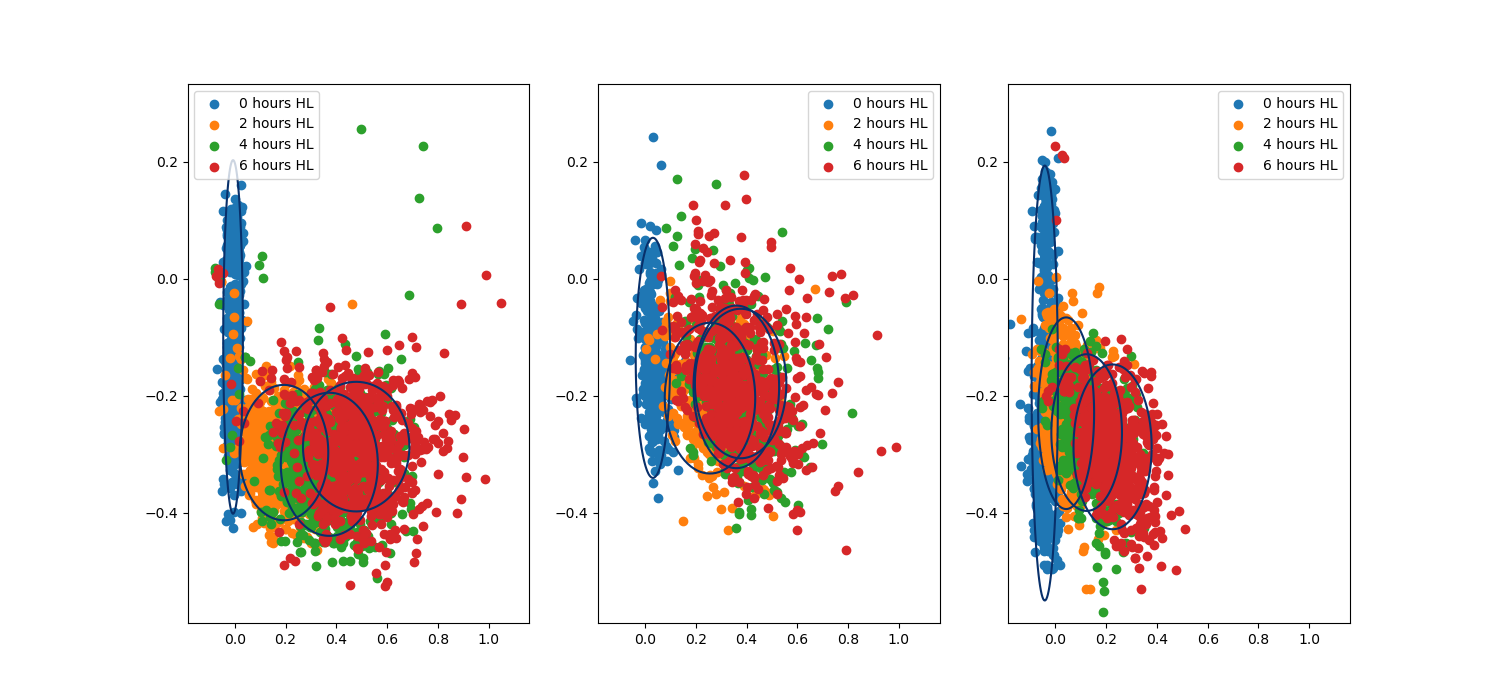

In [14]:



for k, l in [(0,6)]:#list(itertools.combinations(range(6), 2)):
    fig, axs = plt.subplots(1, 3, figsize=(15,7))
    labels = []
    r = [[], [], [], [], [], [], [], []]
    for j, elem in enumerate((WT4, npq4, stt7)):
        for i in range(0,4):
            times = elem.times(elem.measure[i])
            means = elem.means(elem.measure[i])
            r[0] = elem.get_ratio(elem.measure[i], 250, 270)
            r[1] = elem.get_ratio(elem.measure[i], 250, 450)
            r[2] = elem.get_ratio(elem.measure[i], 260, 268)
            r[3] = elem.get_ratio(elem.measure[i], 1150, 450)
            r[4] = elem.get_ratio(elem.measure[i], 1150, 250)
            r[5] = elem.get_ratio(elem.measure[i], 1230, 1150)
            r[6] = elem.get_ratio(elem.measure[i], 270, 450)
            r[7] = elem.get_ratio(elem.measure[i], 260, 264)
            


            labels.append([i]*len(r[0]))


            # Extract x and y
            x = r[k]
            y = r[l]

            m1 = np.mean(x)
            m2 = np.mean(y)
            sigma1 = np.std(x)
            sigma2 = np.std(y)

            # Define the borders
            deltaX = (max(x) - min(x))/10
            deltaY = (max(y) - min(y))/10
            xmin = min(x) - deltaX
            xmax = max(x) + deltaX
            ymin = min(y) - deltaY
            ymax = max(y) + deltaY

            # Create meshgrid
            xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

            z = (1/(2*np.pi*sigma1*sigma2) * np.exp(-((xx-m1)**2/(2*sigma1**2) + (yy-m2)**2/(2*sigma2**2))))
            #plt.imshow(z)
            axs[j].contour(xx, yy, z, levels = [-5, 5], cmap='Blues')
            #plt.plot(times_WT4[-2], means_WT4[-2], label = "%d hours HL"%(2*i))
            axs[j].scatter(x,y, label =  "%d hours HL"%(2*i))

            axs[j].legend()
    plt.setp(axs[1], xlim = axs[0].get_xlim(), ylim=axs[0].get_ylim())
    plt.setp(axs[2], xlim = axs[0].get_xlim(), ylim=axs[0].get_ylim())


In [15]:

labels = []
r = [[], [], [], [], [], [], []]


for j, elem in enumerate((WT4, npq4, stt7)):
    for i in [3]:#range(0,4):
        times = elem.times(elem.measure[i])
        means = elem.means(elem.measure[i])
        r[0].append(elem.get_ratio(elem.measure[i], 250, 270))
        r[1].append(elem.get_ratio(elem.measure[i], 250, 450))
        r[2].append(elem.get_ratio(elem.measure[i], 260, 468))
        r[3].append(elem.get_ratio(elem.measure[i], 1150, 450))
        r[4].append(elem.get_ratio(elem.measure[i], 1150, 250))
        r[5].append(elem.get_ratio(elem.measure[i], 1230, 1150))
        r[6].append(elem.get_ratio(elem.measure[i], 270, 450))

        labels.append([i+4*j]*len(r[0][-1]))


for i in range(len(r)): 
    r[i] = np.concatenate(r[i])
    
labels = np.concatenate(labels)

PCA components:
PCA explained variance:


C:\Users\Alienor\AppData\Local\Temp\ipykernel_15268\927142060.py:31: UserWarning: No contour levels were found within the data range.
  plt.contour(xx, yy, z, levels = [-5, 5], cmap='Blues')


Best score for training data: 0.8852608980857534 

Best C: 1000 

Best Kernel: poly 

Best Gamma: scale 

0.904296875


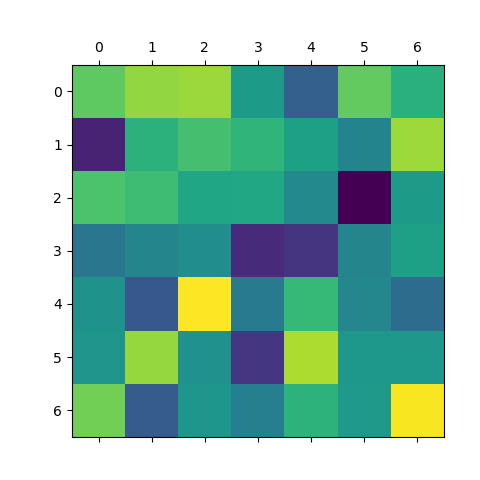

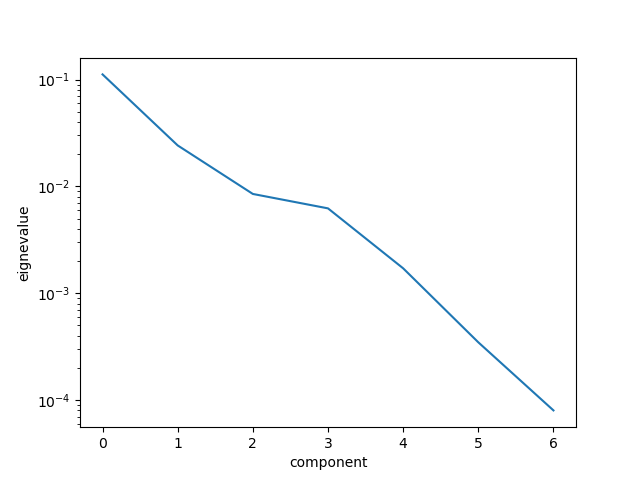

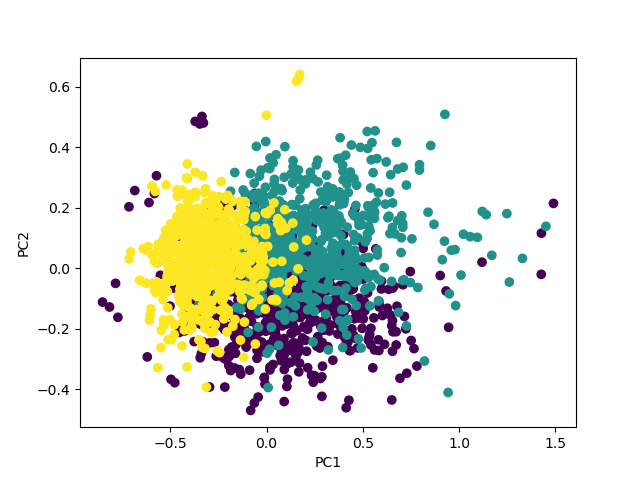

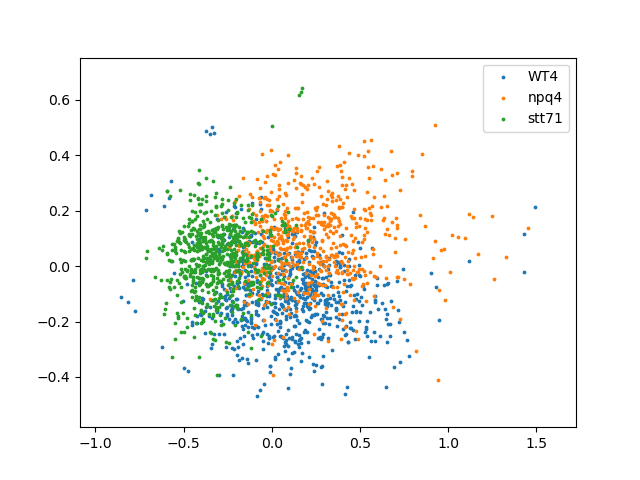

In [7]:
list_ref = np.array(r)
label_new = (labels>3).astype(int) + (labels>7).astype(int)
pca = make_pca(list_ref.shape[0], list_ref.T, label_new)
X = pca.transform(list_ref.T)
x = X[:,0]
y = X[:,1]



m1 = np.mean(x)
m2 = np.mean(y)
sigma1 = np.std(x)
sigma2 = np.std(y)

# Define the borders
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY

# Create meshgrid
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

z = (1/(2*np.pi*sigma1*sigma2) * np.exp(-((xx-m1)**2/(2*sigma1**2) + (yy-m2)**2/(2*sigma2**2))))
#plt.imshow(z)

plt.figure()

plt.contour(xx, yy, z, levels = [-5, 5], cmap='Blues')
#plt.plot(times_WT4[-2], means_WT4[-2], label = "%d hours HL"%(2*i))
for i in range(3):
    plt.scatter(x[label_new==i],y[label_new==i], s = 3, label = ["WT4", "npq4", "stt71"][i])

plt.legend()
plt.setp(axs[1], xlim = axs[0].get_xlim(), ylim=axs[0].get_ylim())



list_ref_svm = (list_ref - np.mean(list_ref, axis = 0))/np.std(list_ref, axis = 0)

final_model = make_svm(list_ref_svm.T, label_new)

(array([ 1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,
         2.,  0.,  2.,  2.,  4.,  5.,  5.,  5.,  8.,  7.,  7., 11., 17.,
         9., 10.,  6., 16., 13., 13., 11., 10., 15.,  9.,  7.,  7.,  4.,
         5.,  4.,  5.,  1.,  1.,  2.,  0.,  3.,  0.,  1.,  2.]),
 array([-0.06881816, -0.05041449, -0.03201083, -0.01360716,  0.0047965 ,
         0.02320017,  0.04160383,  0.0600075 ,  0.07841116,  0.09681483,
         0.11521849,  0.13362216,  0.15202582,  0.17042948,  0.18883315,
         0.20723681,  0.22564048,  0.24404414,  0.26244781,  0.28085147,
         0.29925514,  0.3176588 ,  0.33606247,  0.35446613,  0.3728698 ,
         0.39127346,  0.40967712,  0.42808079,  0.44648445,  0.46488812,
         0.48329178,  0.50169545,  0.52009911,  0.53850278,  0.55690644,
         0.57531011,  0.59371377,  0.61211744,  0.6305211 ,  0.64892477,
         0.66732843,  0.68573209,  0.70413576,  0.72253942,  0.74094309,
         0.75934675,  0.77775042,  0.79615408,  0.81455775,

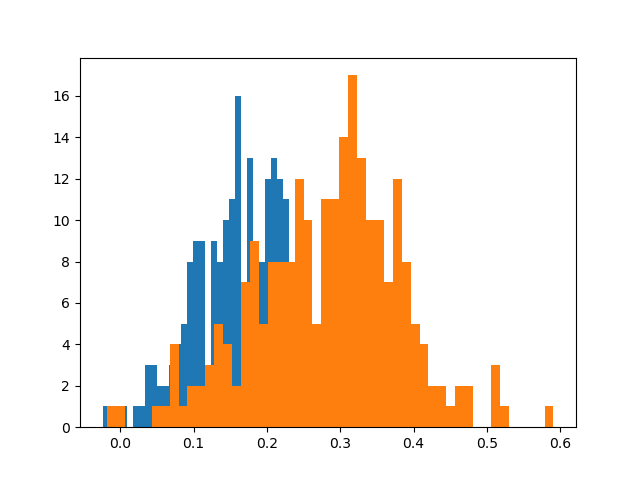

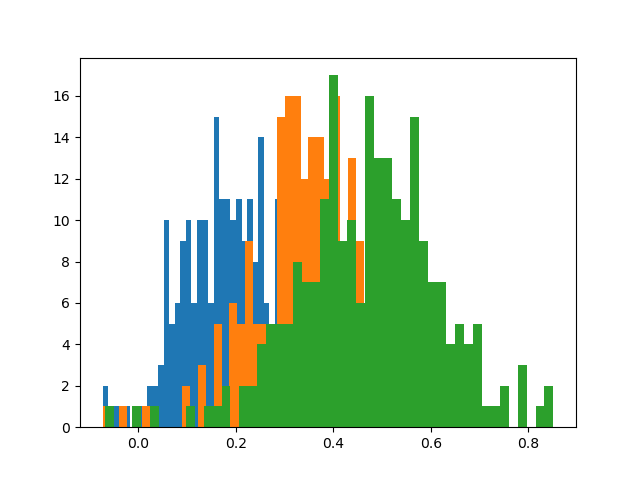

In [9]:
def get_ratio(algae, labels, video, F0, F1):
    F0 = video.get_data(F0)[labels==algae].astype(float)
    F1 = video.get_data(F1)[labels==algae].astype(float)
    return np.mean((F0-F1)/F1)

elem = WT4
start_vid = elem.measure[1][3] + "/video.tiff"
med_vid = elem.measure[2][3] + "/video.tiff"
stop_vid = elem.measure[3][3] + "/video.tiff"
labels = np.load(elem.measure[1][3] + "/items_dict.npy", allow_pickle=True).item()["labels"]
start_vid = imageio.get_reader(start_vid)
stop_vid = imageio.get_reader(stop_vid)
med_vid = imageio.get_reader(med_vid)


rdiff_med = []
rdiff_stop = []

rv1 = [[],[], [],[],[],[],[]]
rv2 = [[],[], [],[],[],[],[]]
rv3 = [[],[], [],[],[],[],[]]


for algae in np.unique(labels)[1:]:
    for i, (F0, F1) in enumerate([(250, 270), (270, 450)]):
        rv1[0].append(get_ratio(algae, labels, start_vid, F0, F1))
        rv2[0].append(get_ratio(algae, labels, med_vid, F0, F1))
        rv3[0].append(get_ratio(algae, labels, stop_vid, F0, F1))

        rdiff_med.append(r1-r0)
        rdiff_stop.append(r2-r0)

        r0tot.append(r0)
        r1tot.append(r1)
        r2tot.append(r2)


plt.figure()
plt.hist(np.array(rdiff_med), bins = 50)
plt.hist(np.array(rdiff_stop), bins = 50)
plt.figure()
plt.hist(np.array(r0tot), bins = 50)
plt.hist(np.array(r1tot), bins = 50)
plt.hist(np.array(r2tot), bins = 50)


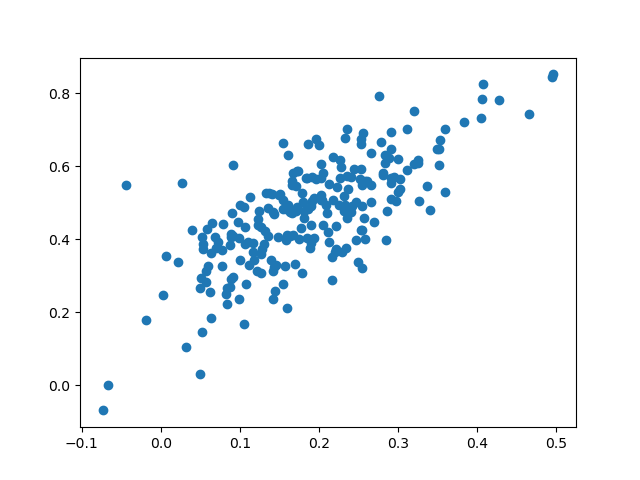

In [10]:
plt.figure()
plt.scatter(r0tot,r2tot)

In [ ]:
2

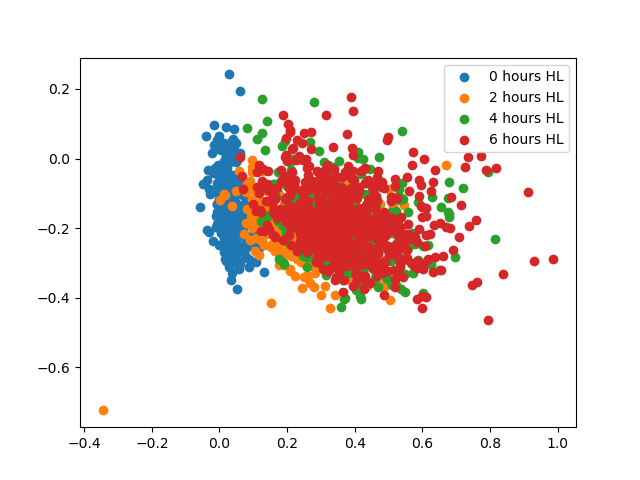

In [16]:

plt.figure()

for i in range(4):
    times_npq4 = npq4.times(npq4.measure[i])
    means_npq4 = npq4.means(npq4.measure[i])
    #plt.plot(times_npq4[-2], means_npq4[-2], label =  "%d hours HL"%(2*i))
    plt.scatter(npq4.get_ratio(npq4.measure[i], 250, 270), npq4.get_ratio(npq4.measure[i], 270, 450), label =  "%d hours HL"%(2*i))
plt.legend()

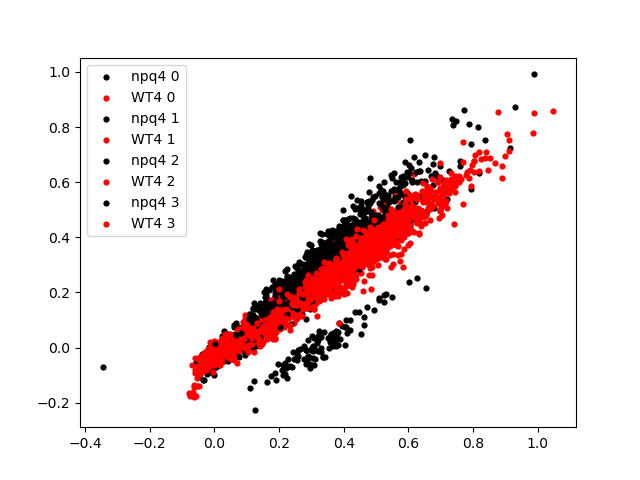

In [17]:
plt.figure()
for i in range(4):
    plt.scatter(npq4.get_ratio(npq4.measure[i], 250, 270), npq4.get_ratio(npq4.measure[i], 260, 268), s = 12, c = "k", label = "npq4 %d"%i)
    plt.scatter(WT4.get_ratio(WT4.measure[i], 250, 270), WT4.get_ratio(WT4.measure[i], 260, 268), s = 12, c = "r", label = "WT4 %d"%i)
plt.legend()

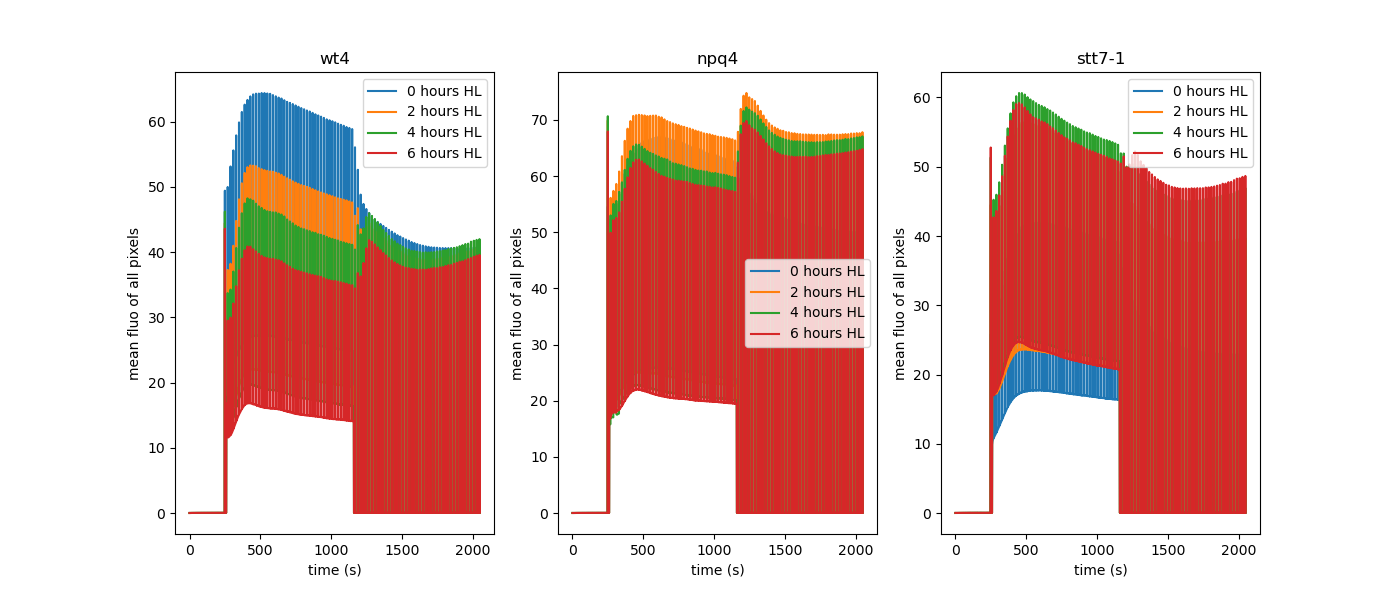

In [27]:
fig, axs = plt.subplots(1, 3, figsize = (14, 6))
for k in range(4):
    for j, elem in enumerate((WT4, npq4, stt7)):
        for i in [k]:# range(4):
            times = elem.times(elem.measure[i])
            means = elem.means(elem.measure[i])
            axs[j].plot(times[-1], means[-1], label = "%d hours HL"%(2*i))
            axs[j].set_title(["wt4", "npq4", "stt7-1"][j])
            axs[j].set_xlabel("time (s)")
            axs[j].set_ylabel("mean fluo of all pixels")
            axs[j].legend()
    plt.savefig("fluo_trace_ENS_induction_HL_%d.pdf"%k)

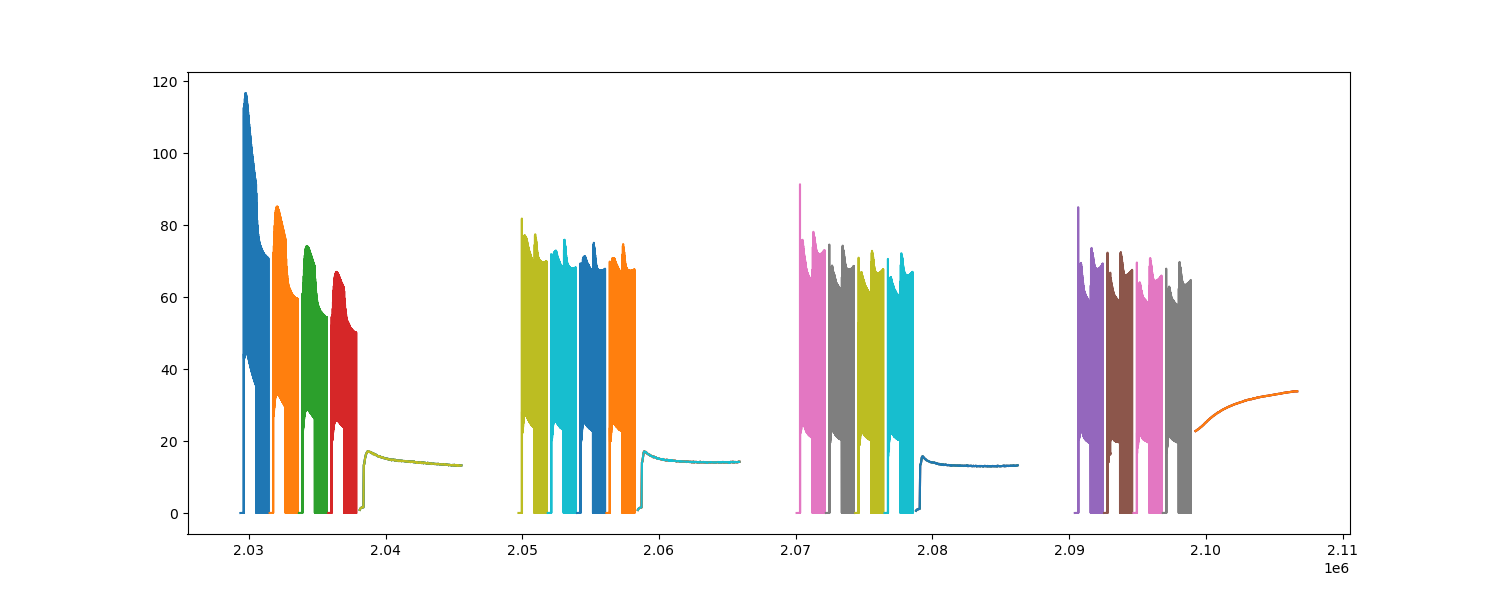

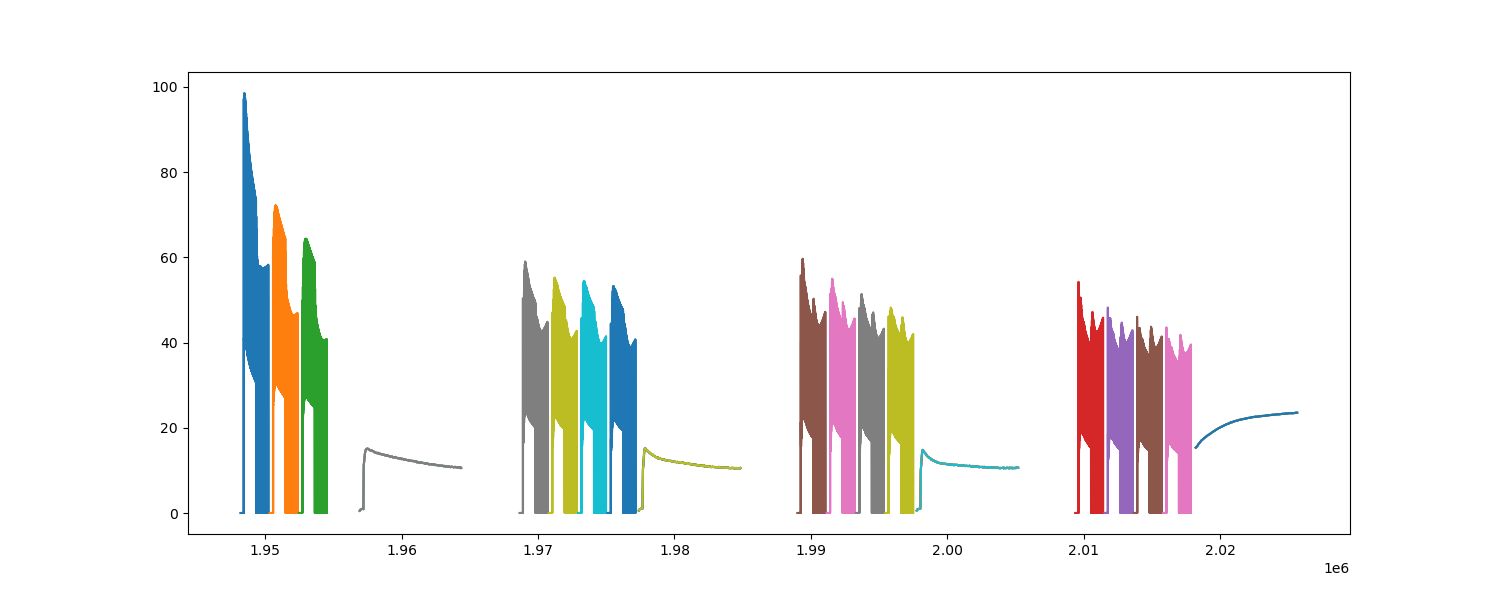

In [227]:
for elem in (npq4, WT4):
    plt.figure(figsize = (15, 6))
    for i in range(4):
        times = elem.times_absolute(elem.measure[i])
        means = elem.means(elem.measure[i])
        plt.plot(times.T, means.T)

        for exp_set in (elem.activation_HL, elem.dark_relaxation):
            times = elem.times_absolute(exp_set)
            pulses = elem.read_pulses(exp_set)
            plt.plot(times.T, pulses.T)

    
    
    


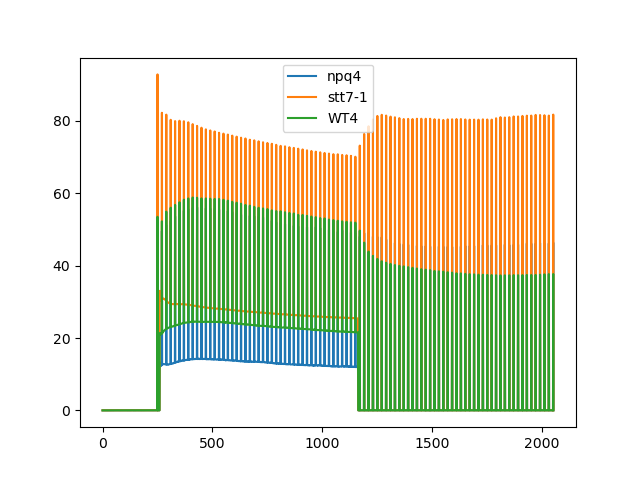

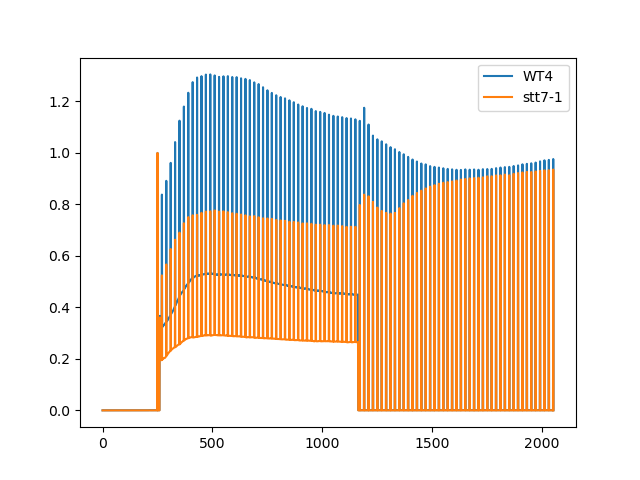

In [10]:
plt.figure()

plt.plot(np.mean(list_npq4_not_act[-1], axis = 0), label = "npq4")
plt.plot(np.mean(list_stt7_not_act[-1], axis = 0), label = "stt7-1")
plt.plot(np.mean(list_WT_not_act[-1], axis = 0), label = "WT4")
plt.legend()

plt.figure()

#plt.plot(np.mean(list_npq4_act[0], axis = 0), label = "npq4")
y= np.mean(list_WT_act[0], axis = 0)
plt.plot(y/y[250], label = "WT4")
y = np.mean(list_stt7_act[0], axis = 0)
plt.plot(y/y[250], label = "stt7-1")

plt.legend()

## Classification with ratios

In [4]:
len(list_stt7_not_act)



3

Best score for training data: 0.7706070287539936 

Best C: 1000 

Best Kernel: poly 

Best Gamma: scale 

0.7782747603833866
PCA components:
PCA explained variance:


'\nplt.figure()\nX = pca.transform(train_data)\nplt.scatter(X[:, 0], X[:, 1], c=Y_train_label, alpha = 0.1, edgecolor=\'none\')##\nvalidation_data = list_ref_svm[(training_set*validation_split).T]\nY_val_label = label[training_set*validation_split]\n\nYval_data = final_model.predict(validation_data)\nXval =  pca.transform(validation_data)\nplt.scatter(Xval[:, 0], Xval[:, 1], c=Y_val_label)##\nprint("number of points train:", len(train_data))\nprint("number of points validation:", len(validation_data))\n      \nprint("accuracy validation:", np.mean(Y_val_label==Yval_data))\n      \n    \nplt.figure()\nX = pca.transform(train_data)\nX2 = pca.transform(list_ref_svm[label==2])\nplt.scatter(X[:, 0], X[:, 1], c=Y_train_label, alpha = 0.1, edgecolor=\'none\')##\nfor k in range(0,3):\n    #plt.figure()\n    position = (label==2)*(video_number==k)\n    test_data = (list_ref_svm)[position.T]\n    Yd = final_model.predict(test_data)\n\n    Xbis = pca.transform(test_data)\n\n    plt.scatter(Xbis[:

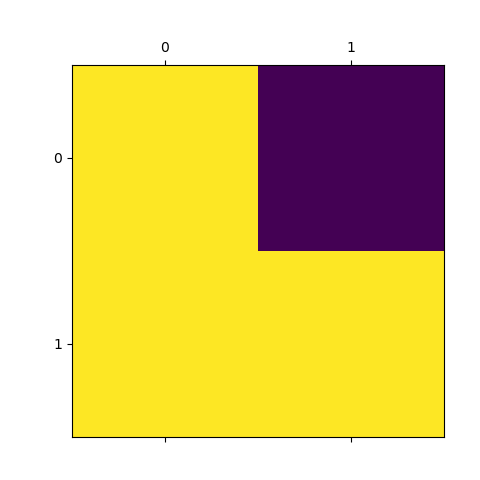

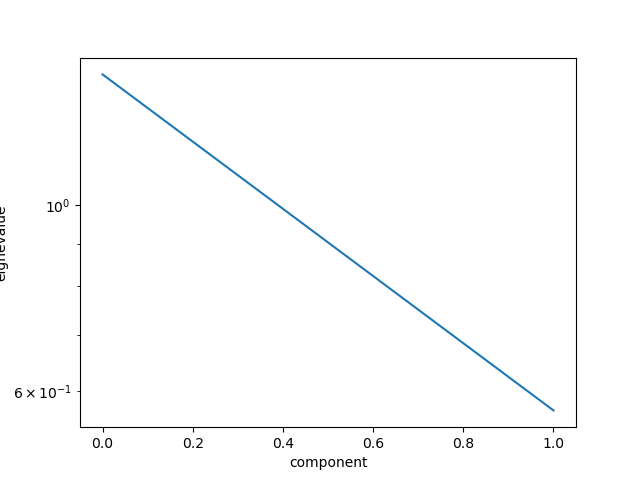

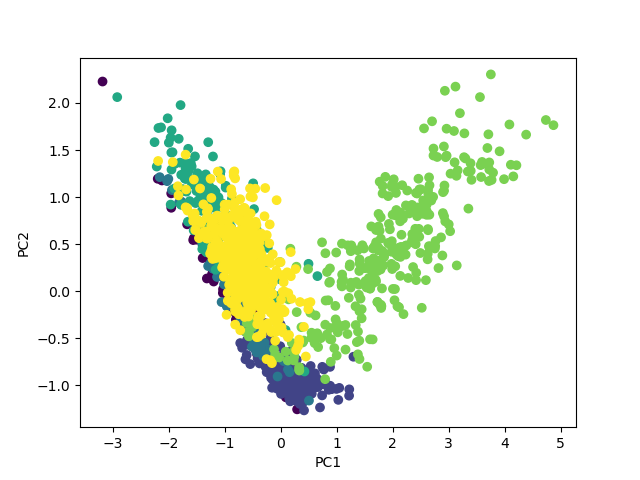

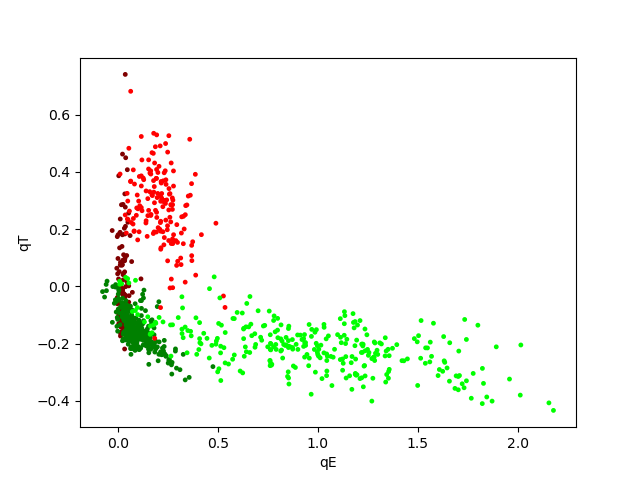

In [7]:
#plt.figure(figsize=(10,10))
lists = [list_WT_not_act, list_stt7_not_act, list_npq4_not_act, list_WT_act, list_stt7_act, list_npq4_act]
colors = np.array([(0.5, 0.0, 0.0, 1), (0.0, 0.5, 0.0, 1), (0.0, 0.0, 0.5, 0), (1.0, 0.0, 0.0, 1), (0.0, 1.0, 0.0, 1), (0.0, 0.0, 1.0, 0)])
N = [0,0,0]


label = []
r1 = []
r2 =  []
r3 = []
r4 = []
r5 = []
r6 = []
r7 = []
r0  = []
video_number = []
color = []
for i, listit in enumerate(lists):
    for p in range(len(listit)):
        for j, y in enumerate(listit[p]): 
                r0.append((y[260] - y[269])/y[269])
                r1.append((-y[271]+y[453])/y[453])
                r2.append((y[250]-y[270])/y[270])
                r3.append((-y[270]+y[450])/y[450])
                r4.append((y[450]-y[1150])/y[1150])
                r5.append((y[1190]-y[1150])/y[1150])
                r6.append((y[2050]-y[1150])/y[1150])
                r7.append((y[450]-y[250])/y[250])
                
                color.append(colors[i])
                label.append(i)
                inds = (y < y.max()*0.4)

                #plt.scatter(r1, r2, color = colors[i])
                #plt.xlabel("ratio qE")
                #plt.ylabel("ratio qT")
                #ax.scatter(r1,r2,r3, c = colors[i])
                video_number.append(p)



def cm(r):
    return np.array(r)#(r-np.mean(r))/(2*np.std(r))



color = np.array(color)
label = np.array(label)
video_number = np.array(video_number)

"""
nodes = points3d(r1, r2, r3, colormap="copper", scale_factor=.01)
nodes.glyph.scale_mode = 'scale_by_vector'

nodes.mlab_source.dataset.point_data.scalars = color
"""

#list_ref = np.array([cm(r0), cm(r1), cm(r2), cm(r3), cm(r4), cm(r5)]).T
list_ref = np.array([cm(r2), cm(r7)]).T

list_ref_svm = (list_ref - np.mean(list_ref, axis = 0))/np.std(list_ref, axis = 0)

training_set = label<7
train_split = (video_number != 5)
validation_split = (video_number==5)
train_data = list_ref_svm[(training_set*train_split).T]
Y_train_label = label[training_set*train_split]



final_model = make_svm(train_data, Y_train_label)

pca = make_pca(list_ref.shape[-1], train_data, Y_train_label)

    
X = pca.transform(train_data)
plt.figure()
X = pca.transform(train_data)
plt.scatter(list_ref[:,0], list_ref[:,1], c=colors[Y_train_label], s = 12, edgecolor='none')
plt.xlabel("qE")
plt.ylabel("qT")

"""
plt.figure()
X = pca.transform(train_data)
plt.scatter(X[:, 0], X[:, 1], c=Y_train_label, alpha = 0.1, edgecolor='none')##
validation_data = list_ref_svm[(training_set*validation_split).T]
Y_val_label = label[training_set*validation_split]

Yval_data = final_model.predict(validation_data)
Xval =  pca.transform(validation_data)
plt.scatter(Xval[:, 0], Xval[:, 1], c=Y_val_label)##
print("number of points train:", len(train_data))
print("number of points validation:", len(validation_data))
      
print("accuracy validation:", np.mean(Y_val_label==Yval_data))
      
    
plt.figure()
X = pca.transform(train_data)
X2 = pca.transform(list_ref_svm[label==2])
plt.scatter(X[:, 0], X[:, 1], c=Y_train_label, alpha = 0.1, edgecolor='none')##
for k in range(0,3):
    #plt.figure()
    position = (label==2)*(video_number==k)
    test_data = (list_ref_svm)[position.T]
    Yd = final_model.predict(test_data)

    Xbis = pca.transform(test_data)

    plt.scatter(Xbis[:,0], Xbis[:,1], c=Yd)
    print(np.sum(Yd)/len(Yd))
    plt.xlabel("PC1")
    plt.ylabel("PC2")

fig = plt.figure()


ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
labs =  label[(label!=2)*train_split]
#for cat in [0,1]:
#    ax.scatter(X[labs==cat,0],X[labs==cat,1],X[labs==cat,2], marker = ".", color = ["k", "r"][cat])

Ytot = []
for k in range(0,3):
    #plt.figure()
    position = (label==2)*(video_number==k)
    test_data = list_ref_svm[position.T]
    Yd = final_model.predict(test_data)
    Ytot.append(Yd)
    print(np.sum(Yd)/len(Yd))

    Xbis = pca.transform(test_data)
    #ax.scatter(Xbis[:,0], Xbis[:,1],Xbis[:,2], color = ["b"])
    
np.save("ydata_ratio.npy", np.concatenate(Ytot))
"""

In [6]:
algae_number=np.array(algae_number)
vid = video_number[ll==2][ind5][inds_train[label0==2]]
alg = algae_number[ll==2][ind5][inds_train[label0==2]]


NameError: name 'algae_number' is not defined

In [96]:
colors[Y_train_label

TypeError: only integer scalar arrays can be converted to a scalar index

mismatch: 11
total: 82


Text(0.5, 1.0, 'compare classifications')

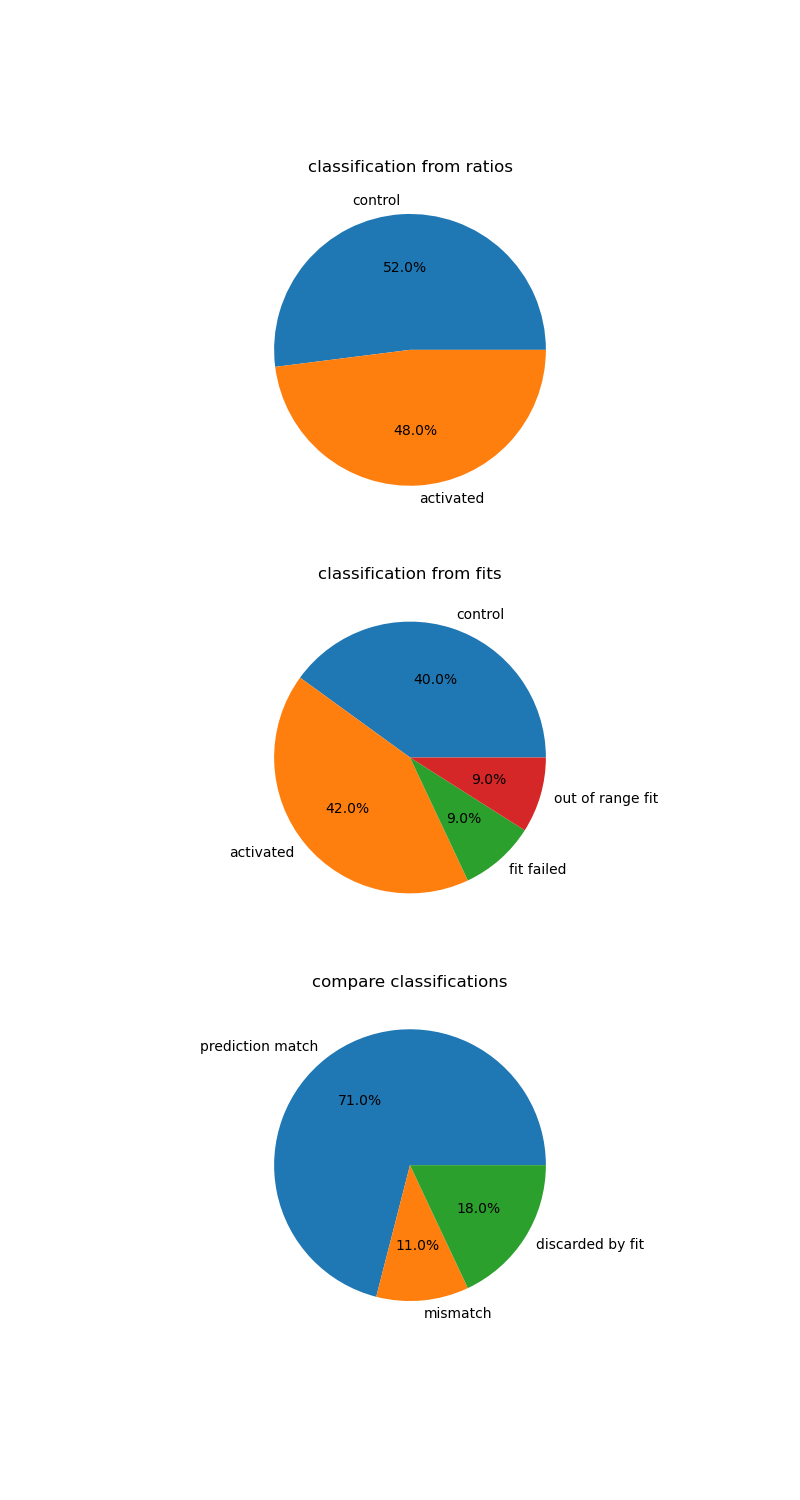

In [113]:
ll = np.array(ll)
Yd0 = np.concatenate(Ytot)
Yd = Yd0[ind5][inds_train[label0==2]]
X2 = X2[ind5][inds_train[label0==2]]
print("mismatch:", np.sum(Yd!=Y_data))
print("total:", len(Yd))

fig, ax = plt.subplots(3,1, figsize=(8,15))
ax[0].pie([np.sum(Yd0==0), np.sum(Yd0==1)], labels = ["control", "activated"], autopct = '%1.1f%%')
ax[0].set_title("classification from ratios")
ax[1].pie([np.sum(Y_data==0), np.sum(Y_data==1), len(Yd0)-len(ind5), len(ind5)-len(Y_data)], labels = ["control", "activated", "fit failed", "out of range fit"], autopct = '%1.1f%%')
ax[1].set_title("classification from fits")
ax[2].pie([np.sum(Yd==Y_data), np.sum(Yd != Y_data), np.sum(len(Yd0) - len(Y_data))], labels = ["prediction match", "mismatch", "discarded by fit"], autopct = '%1.1f%%')
ax[2].set_title("compare classifications")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\Alienor\AppData\Local\Temp/ipykernel_13612/2228085573.py:50: ComplexWarning: Casting complex values to real discards the imaginary part
  xhalf = int(root)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\Alienor\AppData\Local\Temp/ipykernel_13612/2228085573.py:50: ComplexWarning: Casting complex values to real discards the imaginary part
  xhalf = int(root)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in leg

[0.20099255583126552, 14.478493384586134, 4.954530665864128, 0.9467109803345533]
[0.195906432748538, 32.10225258664417, 5.397359413734383, -1.0479328594756088]
[0.104, 1.2897139696077018, 4.730023014203495, 1.0169063305334443]
[-0.053097345132743376, 24.689469176996088, 3.6463071528059667, 0.3725783372009782]
[0.1659090909090909, 2.499968593685714, 6.792597861702404, 1.1315304887391613]
[0.058666666666666714, 0.002775638866101136, 6.776859504132275, -0.19504132231213883]
[0.12981744421906694, 1.0044181519207238, 7.919944539698158, 1.2527032525058746]
[0.06323185011709602, 0.028223527060715882, 7.8374485596707775, -0.5041152263372285]
[0.22047244094488186, 42.07716989587803, 3.588754474695681, 2.1392745777425555]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\Alienor\AppData\Local\Temp/ipykernel_13612/2228085573.py:50: ComplexWarning: Casting complex values to real discards the imaginary part
  xhalf = int(root)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\Alienor\AppData\Local\Temp/ipykernel_13612/2228085573.py:50: ComplexWarning: Casting complex values to real discards the imaginary part
  xhalf = int(root)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in leg

[0.11147540983606555, 0.0017299887699245503, 4.753476611883775, -0.3090321674377644]
[0.14024390243902435, 9.409394364800931, 2.495784866400494, 0.29162850240295823]
[0.15527950310559008, 25.019879276222955, 2.7809437610114087, -0.35686505815467473]
[0.12639405204460968, 0.842842029517612, 12.18281911889705, 2.875974598523332]
[0.07274590163934423, 125.480632192381, 14.309769160059446, -1.4778573134753494]
[0.13147914032869784, 1.0913119772107318, 8.741665882414107, 1.7779981844186585]
[0.022922636103151935, 34.89822740903753, 9.376894673611112, -0.3398812467434247]
[0.05555555555555565, 1.77505830792054, 9.823670621224323, 0.7723782631065099]


C:\Users\Alienor\AppData\Local\Temp/ipykernel_13612/2228085573.py:50: ComplexWarning: Casting complex values to real discards the imaginary part
  xhalf = int(root)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\Alienor\AppData\Local\Temp/ipykernel_13612/2228085573.py:50: ComplexWarning: Casting complex values to real discards the imaginary part
  xhalf = int(root)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\Alienor\AppData\Local\Temp/ipyker

[0.11726384364820838, 32.62174567250094, 11.179843240133776, -1.3039198292378678]
[0.28713858424725824, 1.8051784290073996, 10.307771642462855, 3.1589416632238443]
[0.30691964285714296, 50.02485721397272, 12.183439716601939, -3.4591390789121217]
[0.037878787878787915, 0.7759138065945252, 2.366524128016917, 0.22153897473594578]
[-0.03571428571428559, 4.496197515475342, 2.1925430131153196, 0.06220907491993885]


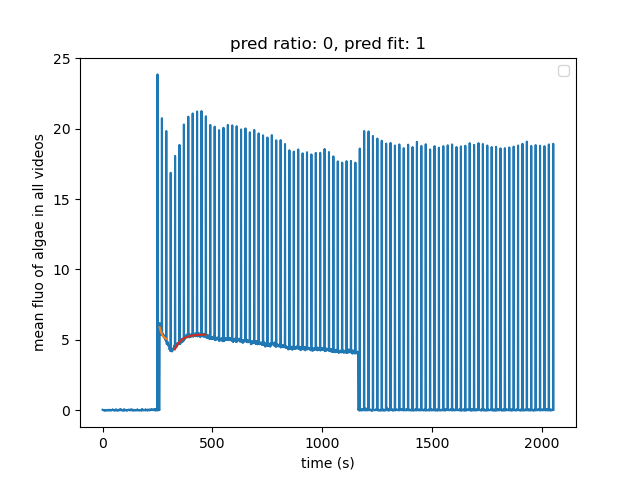

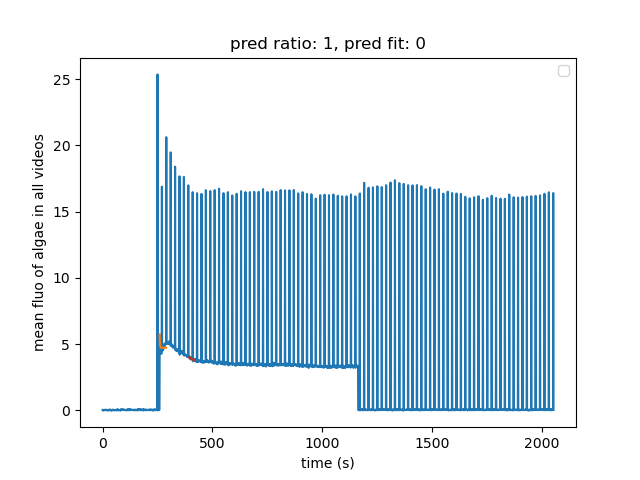

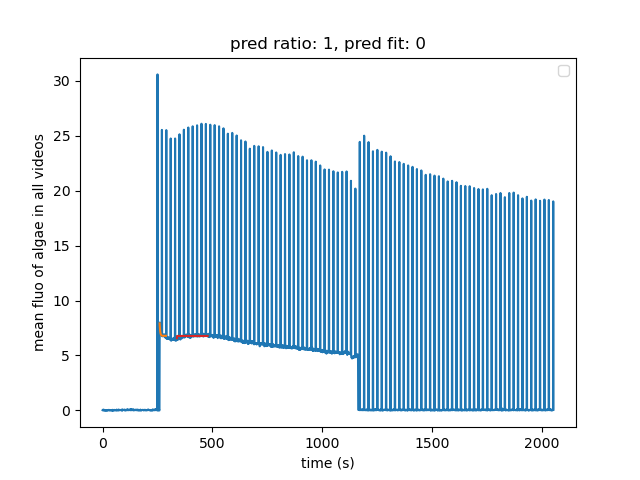

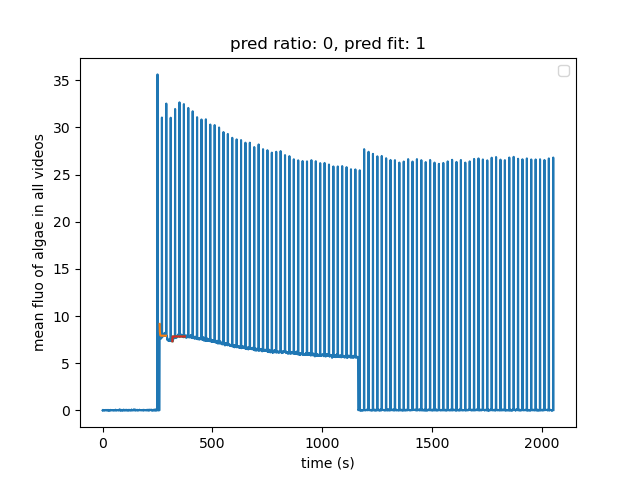

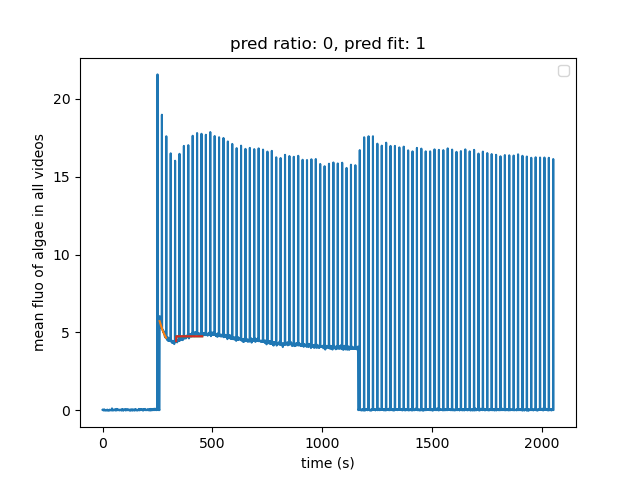

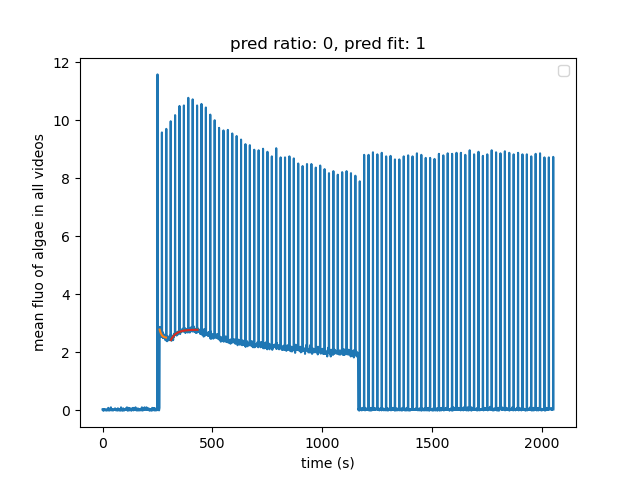

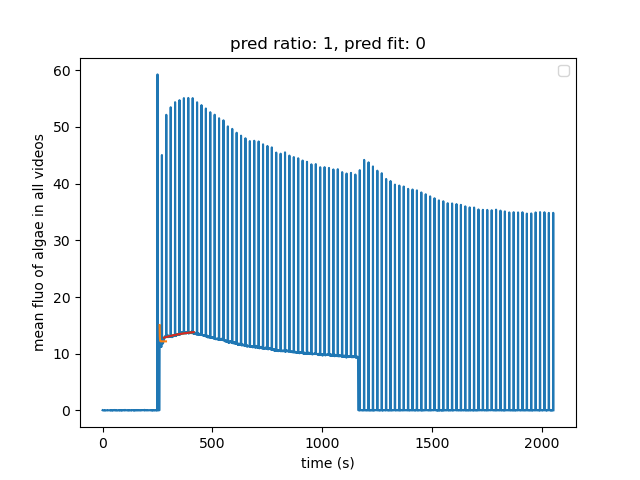

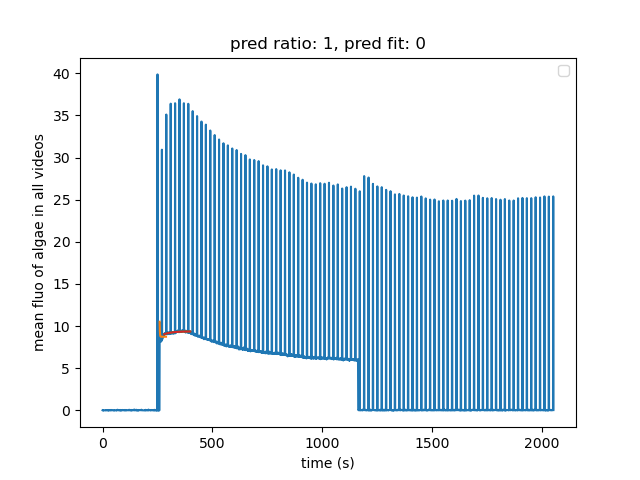

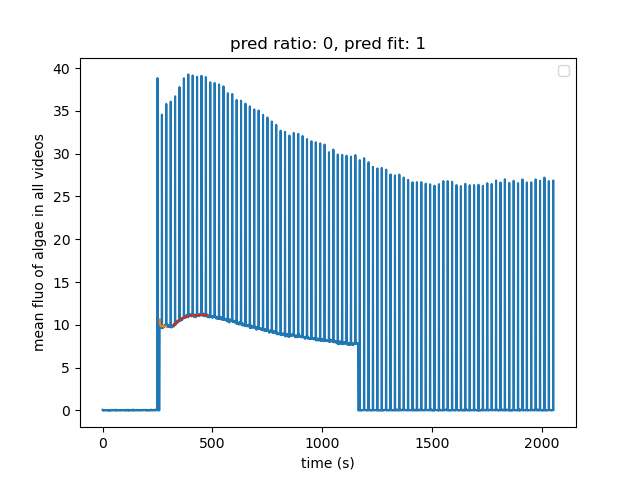

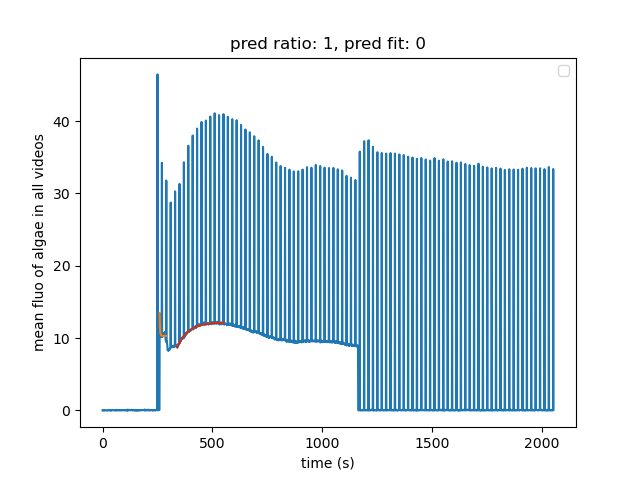

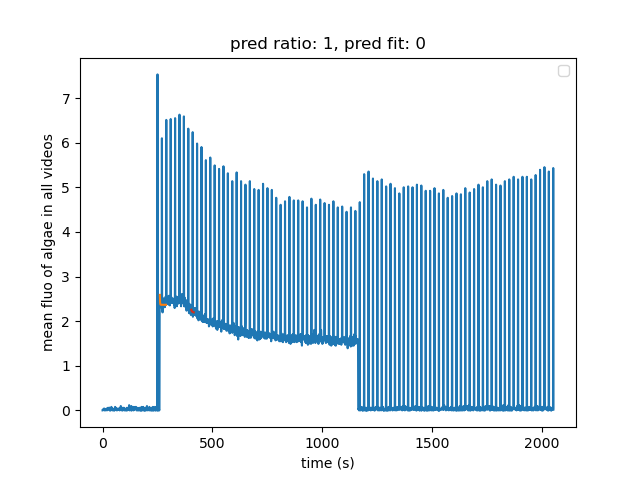

In [114]:
for pos, boo in enumerate(Yd != Y_data):
    if boo == True:
        plt.figure()
        data = list_mix[vid[pos]].item()
        trace = data["items_dict"][alg[pos]]["mean"]
        plt.plot(trace)
        plt.title("pred ratio: %d, pred fit: %d"%(Yd[pos], Y_data[pos]))
        #plt.figure()
        #im = get_algae_im(data["items_dict"][alg[pos]]["x_coords"], data["items_dict"][alg[pos]]["y_coords"], data['im_ref'])
        #plt.imshow(im)
        for start, stop, function_to_fit in [(260, 290, fit_exp), (280, 600, fit_monoexp)]:

            trace0 = trace[start:stop]
            ref =  mean_traces[2][start:stop]

            y, time, ypred, timepred,  *parameters_estimated = function_to_fit(tt[2][j][start:stop], trace0, ref)
            print(parameters_estimated)
            #plt.plot(time, y , label = "control, tau = %0.2f, %0.2f"%(parameters_estimated[1], parameters_estimated[-1]))
            plt.plot(timepred, ypred)

            plt.xlabel("time (s)")
            plt.ylabel("mean fluo of algae in all videos")

            plt.legend()
            
            
            signal = mm[2]




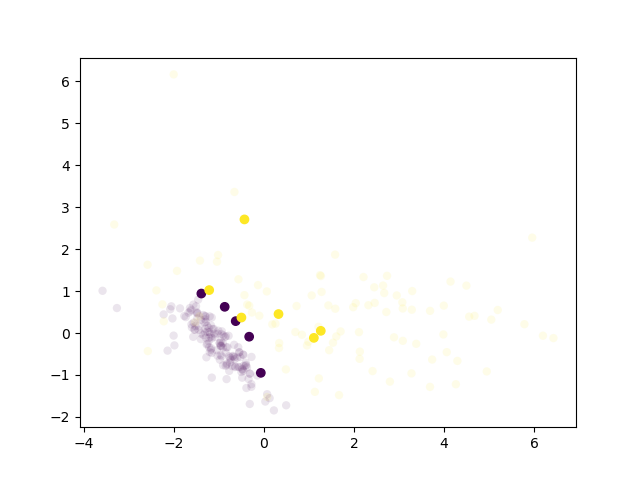

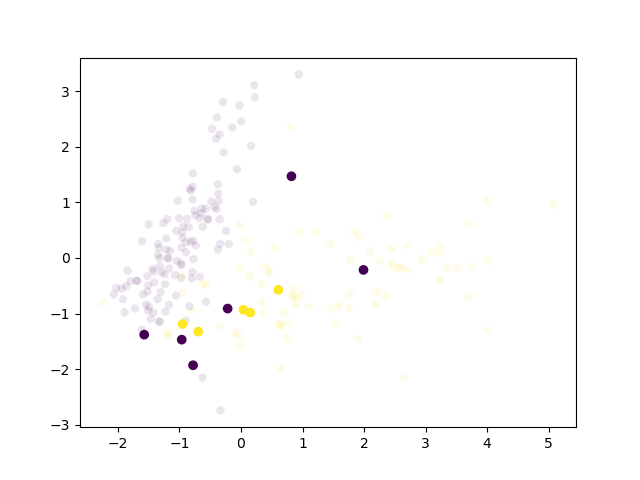

In [115]:
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=Y_train_label, alpha = 0.1, edgecolor='none')##
diff_ind = Yd != Y_data
plt.scatter(X2[diff_ind, 0], X2[diff_ind, 1], c = Yd[diff_ind])
plt.figure()
plt.scatter(X_fits[:, 0], X_fits[:, 1], c=Y_train_label_fits, alpha = 0.1, edgecolor='none')##
plt.scatter(X2_fits[diff_ind, 0], X2_fits[diff_ind, 1], c = Y_data[diff_ind])


### Correlations

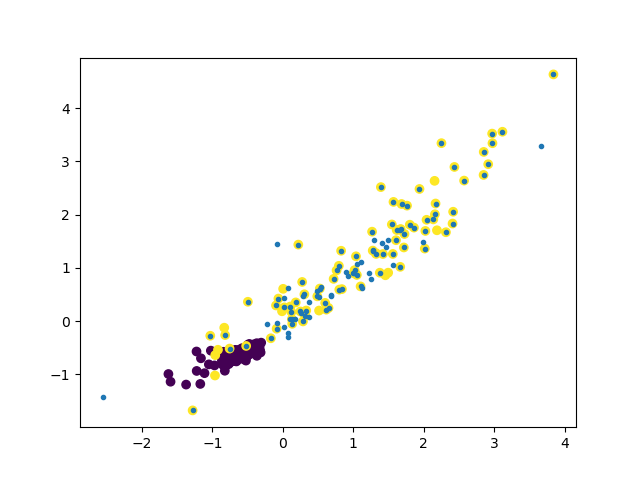

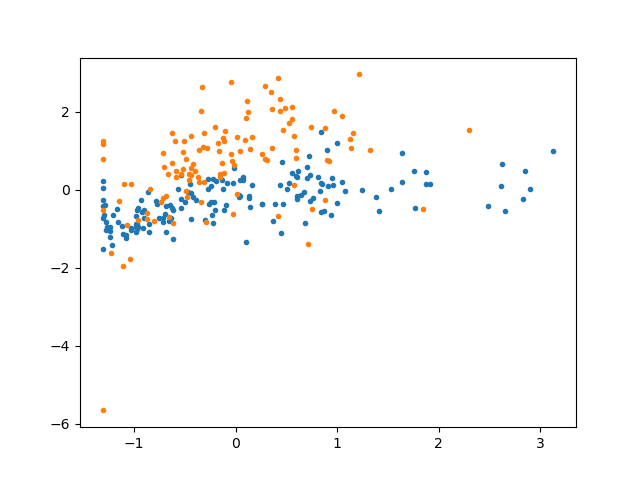

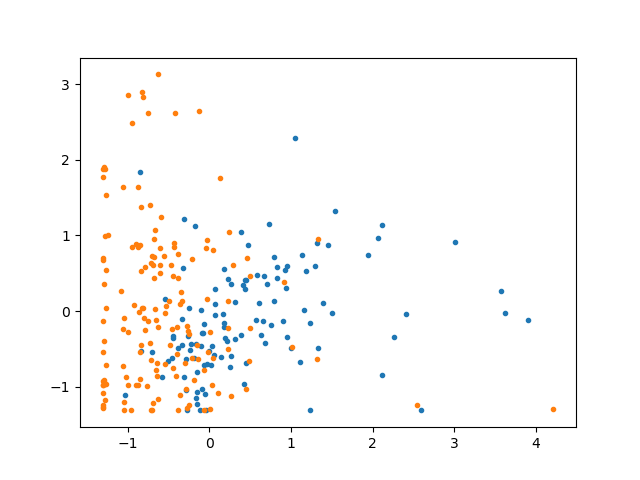

In [172]:
plt.figure()
plt.scatter(train_data[:,0], train_data[:,2],c=Y_train_label)
plt.scatter(list_ref_svm[ll==1][ind3][inds_train[label0==1]][:,0], list_ref_svm[ll==1][ind3][inds_train[label0==1]][:,2], marker = '.')

plt.figure()
plt.scatter(list_ref_svm_fits[labels_fits==0,3], list_ref_svm[ll==0][ind1][inds_train[label0==0]][:,1], marker = '.')
plt.scatter(list_ref_svm_fits[labels_fits==1,3], list_ref_svm[ll==1][ind3][inds_train[label0==1]][:,1], marker = '.')
plt.figure()
plt.scatter(list_ref_svm_fits[labels_fits==1,2], list_ref_svm_fits[labels_fits==1,3], marker = '.')
plt.scatter(list_ref_svm_fits[labels_fits==0,2], list_ref_svm_fits[labels_fits==0,3], marker = '.')


In [160]:
len(list_ref_svm_fits[labels_fits==0])

156

In [145]:
len(ll)

419